### LSTM

In [9]:
import pandas as pd
import numpy as np
data = pd.read_csv('../data/BTC-I.csv', parse_dates=['Date'], index_col=['Date'])
data

,Close,High,Low,Open,Volume,ema20,ema50,rsi10,rsi30,rsi200,macd,signal,hist,Price-Up
Date,,,,,,,,,,,,,,
2015-04-04,253.697006,255.257996,251.100006,254.291000,12493500,255.661524,258.734938,48.021982,48.257672,45.132844,-4.193133,-3.906538,-0.286595,1
2015-04-05,260.597992,260.674988,251.942001,253.761002,19649200,256.131663,258.807999,55.322540,50.163041,45.493022,-3.252122,-3.775655,0.523533,0
2015-04-06,255.492004,261.798004,254.574997,260.721008,20034200,256.070744,258.677960,49.595801,48.787931,45.272028,-2.885117,-3.597547,0.712430,0
2015-04-07,253.179993,255.804993,252.205002,255.274002,18467400,255.795434,258.462354,47.140702,48.169404,45.172167,-2.749132,-3.427864,0.678732,0
2015-04-08,245.022003,253.847000,244.214996,253.063995,30086400,254.769393,257.935281,39.478769,46.038877,44.821560,-3.262042,-3.394700,0.132658,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-15,117398.351562,119332.312500,116864.570312,118365.781250,68665353159,117541.958236,114829.431484,49.285988,54.304271,54.729665,1082.698726,934.380294,148.318432,1
2025-08-16,117491.351562,117996.062500,117271.953125,117398.421875,48036922378,117537.138553,114933.820507,49.594012,54.409111,54.744595,949.171982,937.338632,11.833351,0
2025-08-17,117453.062500,118595.773438,117279.523438,117492.789062,45852169525,117529.131310,115032.614311,49.456598,54.355996,54.737126,830.685839,916.008073,-85.322234,0


In [10]:
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'ema20', 'ema50', 'rsi10', 'rsi30', 'rsi200', 'macd', 'signal', 'hist']
target = ['Price-Up']
# Separar X e y
X = data[features]
y = data[target].to_numpy()
X.shape, y.shape


((3791, 13), (3791, 1))

#### Dividimos el dataset

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3411, 13), (380, 13), (3411, 1), (380, 1))

### Escalamos

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((3411, 13), (380, 13))

#### Creamos las secuencias

In [13]:
sequence_length = 30 
X_train_sequences = []
y_train_sequences = []
X_test_sequences = []
y_test_sequences = []
for i in range(sequence_length, len(X_train)): 
    X_train_sequences.append(X_train_scaled[i - sequence_length: i])
    y_train_sequences.append(y_train[i])

for i in range(sequence_length, len(X_test)): 
    X_test_sequences.append(X_test_scaled[i - sequence_length: i])
    y_test_sequences.append(y_test[i])

X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)
X_test_sequences = np.array(X_test_sequences)
y_test_sequences = np.array(y_test_sequences)
X_train_sequences.shape, y_train_sequences.shape, X_test_sequences.shape, y_test_sequences.shape
#Aca optenemos la (cantidad de secuencias(ventanas), cantidad de dias, cantidad de features)

((3381, 30, 13), (3381, 1), (350, 30, 13), (350, 1))

### Pytorch Implementation

In [14]:
# Convertimos los datos a tensores 
import torch
X_train_tensor = torch.tensor(X_train_sequences, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_sequences, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sequences, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_sequences, dtype=torch.float32)

X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape 

(torch.Size([3381, 30, 13]),
 torch.Size([350, 30, 13]),
 torch.Size([3381, 1]),
 torch.Size([350, 1]))

#### Arquitectura 

In [16]:
import torch
import torch.nn as nn
# Creamos la clase o sub-clase de nn.Module 
# Creamos dos metodos init y forward

class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        # Definimos una capa LSTM y un full connected layer

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        
    def forward(self, x):
        # Inicializamos los vectores de estado oculto y de celda con ceros 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:,-1,:] 
        out = self.fc(out) 
        return out

13

In [23]:
# Cada instanacia lo movemos a la gpu
import torch

# Parameters of the model 
input_size = X_train_tensor.shape[2]  # 13
hidden_size = 128
num_layers  = 4
output_size = 1 # Classification 


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = MyLSTM(input_size, hidden_size, num_layers, output_size).to(device)
print(model)



Using device: cpu
MyLSTM(
  (lstm): LSTM(13, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [24]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor) # Instanciamos la clase  
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size, shuffle=True) # Instanciamos la clase DataLoader
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print(len(train_loader))
for batch_X, batch_y in train_loader:
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)
    # Solo el primer batch
    break


106
Batch X shape: torch.Size([32, 30, 13])
Batch y shape: torch.Size([32, 1])


In [33]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 100 
model.train()
print(f'Training on {device}')

for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device) #[32, 30, 8]
        batch_y = batch_y.to(device) #[32, 1]
        # Forward pass
        outputs = model(batch_X).squeeze() # [batch_size, 1] => [batch_size] 

        loss = criterion(outputs, batch_y.squeeze())

        # Backward pass
        loss.backward()

        optimizer.step()

        optimizer.zero_grad()
    if (epoch + 1 ) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')





Entrenado en cpu
Epoch [10/100], Loss: 0.6866
Epoch [20/100], Loss: 0.7056
Epoch [30/100], Loss: 0.7037
Epoch [40/100], Loss: 0.6922
Epoch [50/100], Loss: 0.7169
Epoch [60/100], Loss: 0.6921
Epoch [70/100], Loss: 0.6775
Epoch [80/100], Loss: 0.6862
Epoch [90/100], Loss: 0.6921
Epoch [100/100], Loss: 0.6921


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
import torch
import numpy as np

model.eval()  # Modo de evaluación

y_true = []  # Etiquetas reales
y_pred = []  # Predicciones binarias
y_probs = []  # Probabilidades predichas

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        # Forward pass
        outputs = model(batch_X).squeeze()   # Logits
        probs = torch.sigmoid(outputs)       # Probabilidades
        predicted = torch.round(probs)       # Predicciones binarias (0 o 1)

        # Guardar los valores reales y predichos
        y_true.extend(batch_y.view(-1).cpu().numpy())  # Solución aquí ✅
        y_pred.extend(predicted.view(-1).cpu().numpy())
        y_probs.extend(probs.view(-1).cpu().numpy())

# Convertir listas a numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)
report = classification_report(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# Mostrar resultados
print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')
print(report)
print(conf_matrix)



Accuracy: 0.52%
Precision: 0.52
Recall: 1.00
F1-Score: 0.68
ROC-AUC: 0.55
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       169
         1.0       0.52      1.00      0.68       181

    accuracy                           0.52       350
   macro avg       0.26      0.50      0.34       350
weighted avg       0.27      0.52      0.35       350

[[  0 169]
 [  0 181]]


/Users/ivotonioni/miniconda3/envs/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ivotonioni/miniconda3/envs/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ivotonioni/miniconda3/envs/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

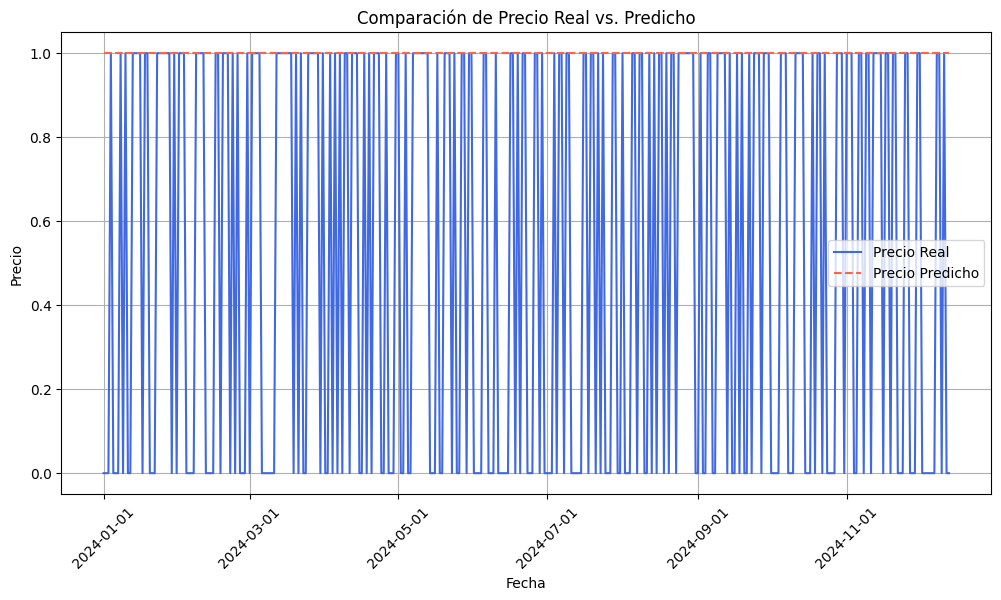

In [32]:
import matplotlib.dates as mdates 
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que tienes un DataFrame con fechas
fechas = pd.date_range(start="2024-01-01", periods=len(y_true), freq="D")

plt.figure(figsize=(12, 6))
plt.plot(fechas, y_true, label="Precio Real", color='royalblue')
plt.plot(fechas, y_pred, label="Precio Predicho", color='tomato', linestyle='dashed')

# Mejorar formato de fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato Año-Mes-Día
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-ajuste de fechas

plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Comparación de Precio Real vs. Predicho")
plt.legend()
plt.grid(True)

plt.show()
